In [1051]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn 
import plotly.express as px

# Домашняя работа: деревья решений

В этой домашней работе вам предстоит научиться предсказывать цены товаров из маркетплейса Azamon.

Требования к домашней работе:
- Во всех графиках должны быть подписи через title, legend, etc.
- Во время обучения моделей проверяйте, что у вас не текут данные. Обычно это позитивно влияет на качество модели на тесте, но негативно влияет на оценку 🌚
- Если вы сдаете работу в Google Colaboratory, убедитесь, что ваша тетрадка доступна по ссылке.
- Использование мемов допускается, но необходимо соблюдать меру. Несодержательная работа, состоящая только из мемов, получает 0 баллов.

# Загрузка и подготовка данных

In [1052]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1053]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MAI/HomeWork/amazon_co-ecommerce_sample.csv').drop(columns=[
    'product_name',
    'index',
    'uniq_id',
    'customers_who_bought_this_item_also_bought',
    'items_customers_buy_after_viewing_this_item',
    'sellers',
    'description', # text
    'product_information', # text
    'product_description', # text
    'customer_questions_and_answers', # text
    'customer_reviews', # text
])

In [1054]:
df.head()

,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category
0,Hornby,£3.42,5 new,15,1.0,4.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...
1,FunkyBuys,£16.99,NaN,2,1.0,4.5 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...
2,ccf,£9.99,2 new,17,2.0,3.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...
3,Hornby,£39.99,NaN,1,2.0,5.0 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...
4,Hornby,£32.19,NaN,3,2.0,4.7 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...


## Очистка данных (1 балл)

Посмотрите на признаки. Есть ли в них пропуски? Какое соотношение между NaN'ами и общим количеством данных? Есть ли смысл выкидывать какие-либо данные из этого датасета?

In [1055]:
df.isnull().sum()

manufacturer                           7
price                               1435
number_available_in_stock           2500
number_of_reviews                     18
number_of_answered_questions         765
average_review_rating                 18
amazon_category_and_sub_category     690
dtype: int64

In [1056]:
df.isnull().sum() / (df.notnull().sum() + df.isnull().sum())

manufacturer                        0.0007
price                               0.1435
number_available_in_stock           0.2500
number_of_reviews                   0.0018
number_of_answered_questions        0.0765
average_review_rating               0.0018
amazon_category_and_sub_category    0.0690
dtype: float64

In [1057]:
df = df.drop(columns = ['number_available_in_stock'])
df.head()

,manufacturer,price,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category
0,Hornby,£3.42,15,1.0,4.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...
1,FunkyBuys,£16.99,2,1.0,4.5 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...
2,ccf,£9.99,17,2.0,3.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...
3,Hornby,£39.99,1,2.0,5.0 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...
4,Hornby,£32.19,3,2.0,4.7 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...


## Подготовка данных (3 балла)

Обработайте признаки. Выполните кодирование категориальных признаков, заполните пропуски в числовых признаках. Обратите внимание, что в датасете есть признак, который разбивается на несколько подпризнаков. Что это за признак? Закодируйте и его.

Дополнительные вопросы (+ 1 балл):
- Какие из признаков в этом датасете лучше кодировать через ordinal encoding?
- Какие из признаков допустимо кодировать через one-hot?

Прим.: суммарно за эту секцию можно получить до 4 баллов.

In [1058]:
# df['amazon_category_and_sub_category'].unique()
new_df = df['amazon_category_and_sub_category'].str.split(' > ',expand=True)
new_df.columns=['sub_category_0','sub_category_1','sub_category_2', 'sub_category_3', 'sub_category_4']
final_df = pd.concat([df,new_df], axis = 1)
final_df = final_df.drop('amazon_category_and_sub_category', axis = 1)
df = final_df
df['sub_category_0'] = pd.factorize(df['sub_category_0'])[0] + 1
df['sub_category_1'] = pd.factorize(df['sub_category_1'])[0] + 1
df['sub_category_2'] = pd.factorize(df['sub_category_2'])[0] + 1
df['sub_category_3'] = pd.factorize(df['sub_category_3'])[0] + 1
df['sub_category_4'] = pd.factorize(df['sub_category_4'])[0] + 1

df['number_of_reviews'] = df['number_of_reviews'].str.replace(',','')
df['number_of_reviews'] = df['number_of_reviews'].astype(float)

one_hot = pd.get_dummies(df['manufacturer'])
df = df.drop('manufacturer',axis = 1)
df = df.join(one_hot)
df['average_review_rating'] = df['average_review_rating'].str.split(expand=True)[:][0].astype(float)
df

,price,number_of_reviews,number_of_answered_questions,average_review_rating,sub_category_0,sub_category_1,sub_category_2,sub_category_3,sub_category_4,101,...,ukgiftstoreonline,unbespielt,uni-ball,unisex party bag fillers,universal hobby,woooow doll,xs-party,yugioh,zizzi,|MFG
0,£3.42,15.0,1.0,4.9,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,£16.99,2.0,1.0,4.5,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,£9.99,17.0,2.0,3.9,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,£39.99,1.0,2.0,5.0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,£32.19,3.0,2.0,4.7,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,£22.95,3.0,3.0,5.0,1,29,13,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,£39.99,1.0,3.0,4.0,2,4,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,£43.99,1.0,3.0,5.0,29,67,3,21,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,£49.81,1.0,3.0,5.0,1,29,13,0,0,0,...,0,0,0,0,0,0,0,0,0,0


 Еще "£2,439.92"
 
 Цены типа: "£269.00 - £699.99"

 Берем среднее

In [1059]:
df['price'] = df['price'].str.replace('£','')
df['price'] = df['price'].str.replace(',','')
s = df['price'].str.replace('- ','')
s = s.str.split(expand=True)
s[0] = s[0].astype(float)
s[1] = s[1].astype(float)
s = s.mean(axis = 1)
df['price'] = s

In [1060]:
df['price'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 10000 entries, 0 to 9999
Series name: price
Non-Null Count  Dtype  
--------------  -----  
8565 non-null   float64
dtypes: float64(1)
memory usage: 78.2 KB


In [1061]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 2660 entries, price to |MFG
dtypes: float64(4), int64(5), uint8(2651)
memory usage: 26.0 MB


In [1062]:
df = df.dropna()
df

,price,number_of_reviews,number_of_answered_questions,average_review_rating,sub_category_0,sub_category_1,sub_category_2,sub_category_3,sub_category_4,101,...,ukgiftstoreonline,unbespielt,uni-ball,unisex party bag fillers,universal hobby,woooow doll,xs-party,yugioh,zizzi,|MFG
0,3.42,15.0,1.0,4.9,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,16.99,2.0,1.0,4.5,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9.99,17.0,2.0,3.9,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,39.99,1.0,2.0,5.0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,32.19,3.0,2.0,4.7,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,22.95,3.0,3.0,5.0,1,29,13,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9996,39.99,1.0,3.0,4.0,2,4,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9997,43.99,1.0,3.0,5.0,29,67,3,21,0,0,...,0,0,0,0,0,0,0,0,0,0
9998,49.81,1.0,3.0,5.0,1,29,13,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1063]:
df['number_of_reviews'].info()

<class 'pandas.core.series.Series'>
Int64Index: 7876 entries, 0 to 9999
Series name: number_of_reviews
Non-Null Count  Dtype  
--------------  -----  
7876 non-null   float64
dtypes: float64(1)
memory usage: 123.1 KB


# Обучение модели (3 балла)

In [1064]:
from sklearn.model_selection import train_test_split
y = df['price']
X = df.drop(columns = ['price'])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=42)

## Бейзлайн

Обучите базовую модель. Для этого используйте `sklearn.dummy.DummyRegressor`. Какое качество она показывает на тесте? Посчитайте MSE, RMSE.

In [1065]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

dummy_regr = DummyRegressor(strategy="mean").fit(X_train, y_train)
y_pred = dummy_regr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(mse)

rmse = np.sqrt(mse)
print(rmse)

r2 = r2_score(y_test, y_pred)
r2

1542.4419897696644
39.27393524679777


-0.00779236230335667

## Дерево решений

Обучите регрессионное дерево решений, проверьте качество этой модели на тестовой выборке. Улучшилось ли качество по сравнению с базовой моделью? Оцените r2_score обученной модели.

In [1066]:
from sklearn.tree import DecisionTreeRegressor


clf = DecisionTreeRegressor()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

r2 = r2_score(y_test, y_pred)
r2

-0.2841234438830105

## Линейная регрессия

Попробуйте обучить линейную регрессию с параметрами по умолчанию. Оцените r2_score на тестовой выборке. Сравните качество с деревом решений. 

In [1067]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)

y_pred = reg.predict(X_test)

r2 = r2_score(y_test, y_pred)
r2

-6.309106086736809e+19

# Гиперпараметры (2 балла)

Переберите несколько гиперпараметров (не более двух-трёх). Обратите внимание, как эти параметры влияют на ошибку модели на тестовой выборке. Постройте для глубины дерева график переобучения (fitting curve) аналогичный тому, что мы строили на занятии. Найдите глубину дерева, начиная с которой модель начинает переобучаться.

In [1068]:
import seaborn as sns
from tqdm import tqdm


def plot_fitting_curve(
    model_ctor, parameter: str, values: list, score, X_train, X_test, y_train, y_test
):
    train_curve = []
    test_curve = []
    for value in tqdm(values):
        model = model_ctor(**{parameter: value}) 
        model.fit(X_train, y_train)
        y_pred_train, y_pred_test = model.predict(X_train), model.predict(X_test)
        train_curve.append(score(y_train, y_pred_train))
        test_curve.append(score(y_test, y_pred_test))
    sns.lineplot(x=values, y=train_curve)
    sns.lineplot(x=values, y=test_curve)

100%|██████████| 29/29 [00:16<00:00,  1.74it/s]


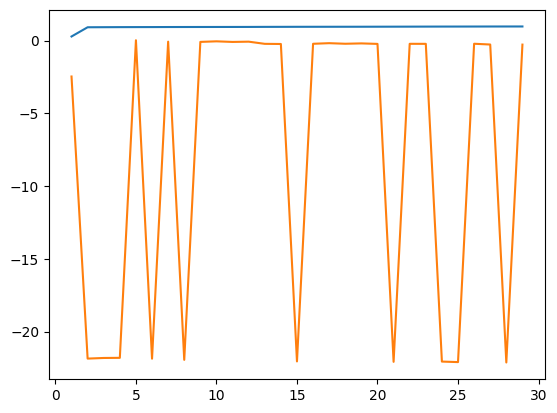

In [1077]:
plot_fitting_curve(DecisionTreeRegressor, 'max_depth', np.arange(1, 30), r2_score, X_train, X_test, y_train, y_test)

100%|██████████| 28/28 [00:19<00:00,  1.41it/s]


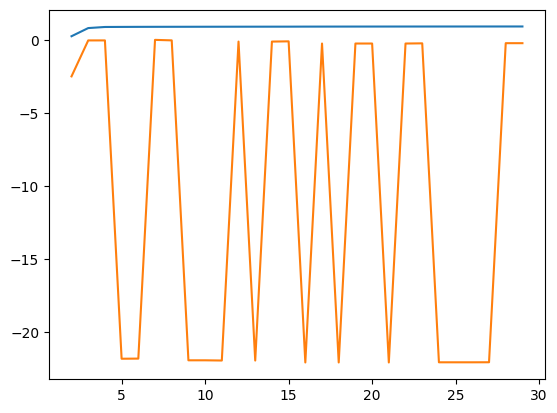

In [1078]:
plot_fitting_curve(DecisionTreeRegressor, 'max_leaf_nodes', np.arange(2, 30), r2_score, X_train, X_test, y_train, y_test)

# Простое ансамблирование (1 балл)

В этой секции мы реализуем простой ансамбль деревьев.

In [1070]:
class EnsembleTreeRegressor:
    def __init__(self, num_trees=5, samples_frac=0.8, **model_kwargs):
        self.num_trees= num_trees
        self._samples_frac = 0.8
        self._trees = [DecisionTreeRegressor(**model_kwargs) for _ in range(num_trees)]
    def fit(self, x, y: pd.Series):
        x = pd.DataFrame(x)
        y = y.reset_index(drop=True)
        for tree in self._trees:
            tree_x = x.sample(frac=self._samples_frac, random_state=42)
            tree_y = y[tree_x.index]
            tree.fit(tree_x, tree_y)
        return self

    def predict(self, x: pd.DataFrame):
        x = pd.DataFrame(x)
        res = []
        for i in range(self.num_trees):
          res.append(self._trees[i].predict(x))
        return sum(res) / len(res)

Проверьте, работает ли этот ансамбль лучше обычного дерева с параметрами по умолчанию?

Дополнительно переберите максимальную глубину дерева. Проверьте, насколько отличается момент начала переобучения у одиночного дерева и у ансамбля. Зависит ли этот момент от числа деревьев (`num_trees`)? От числа примеров для каждого дерева (`samples_frac`)? Постройте график fitting curve.